In [96]:
import torch
from torch import nn
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.manifold import TSNE

from models.modules import SimpleNet
from models.effnet import efficientnet_b0
from datasets import prepare_data_loaders

from config import config
%matplotlib inline
sns.set()


def plot_images(imgs, names=None):        
    fig, axs = plt.subplots(ncols=len(imgs), figsize=(16, 8))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i])
        ax.set_axis_off()
        if names and i < len(names):
            ax.set_title(names[i], fontsize=15)
    plt.show()
    
def plot_image(img, img_size=5):
    img = np.array(img)

    height, width = img.shape[:2]
    fig = plt.figure()
    fig.set_size_inches(width / height * img_size, img_size, forward=True)
    ax = plt.Axes(fig, [0., 0., 1, 1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img)

    plt.show()
    
def draw_components(mask):
    ret, labels = cv2.connectedComponents(mask)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plot_image(labeled_img)
    return labels
    
def centroid(contour, img):
    height, wigth = img.shape[:2]
    midx, midy = contour.mean(axis=0) / (wigth, height)
    return (1 - midy) * midy * (1 - midx) * midx

In [2]:
train_data = sio.loadmat('data/SVHN/train_32x32.mat')
test_data = sio.loadmat('data/SVHN/test_32x32.mat')

# access to the dict
x_train = train_data['X'].transpose(3, 0, 1, 2)
y_train = train_data['y'].reshape(-1)

x_test = test_data['X'].transpose(3, 0, 1, 2)
y_test = test_data['y'].reshape(-1)

In [3]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [5]:
mnist_data_test, mnist_label_test = torch.load('data/MNIST/processed/test.pt')
mnist_data_test = torch.stack([mnist_data_test]*3, dim=-1).numpy()
mnist_label_test = mnist_label_test.numpy()

mnist_data_train, mnist_label_train = torch.load('data/MNIST/processed/training.pt')
mnist_data_train = torch.stack([mnist_data_train]*3, dim=-1).numpy()
mnist_label_train = mnist_label_train.numpy()

In [98]:
model_baseline = efficientnet_b0(num_classes=10).cuda().eval()
model_baseline.load_state_dict(torch.load('checkpoints/effnet_740_reserved.pth'))

model = SimpleNet(num_classes=10).cuda().eval()
model.load_state_dict(torch.load('checkpoints/simplenet_arcface_992.pth'))

mnist_loaders = prepare_data_loaders(config['mnist'], ['train', 'valid'])
loaders = prepare_data_loaders(config['svhn'], ['train', 'valid'])
loaders['target_train'] = mnist_loaders['train']
loaders['target_valid'] = mnist_loaders['valid']
loaders['source_train'] = loaders.pop('train')
loaders['source_valid'] = loaders.pop('valid')

In [9]:
def get_features(loader, model):
    features = []
    outputs = []
    idxs = []
    targets = []
    criterion = nn.CrossEntropyLoss(reduction='none')

    for batch in tqdm(loader):
        for key in batch:
            batch[key] = batch[key].cuda()

        with torch.no_grad():
            output, feature = model.forward_logits_and_features(batch['input'])
        outputs.append(output.cpu())
        features.append(feature.cpu())
        targets.append(batch['target'].cpu())
        idxs.append(batch['index'].cpu())

    outputs = nn.functional.softmax(torch.cat(outputs), dim=1)
    features = torch.cat(features)
    idxs = torch.cat(idxs)
    targets = torch.cat(targets)
    print(f"Accuracy: {(targets == outputs.argmax(dim=1)).float().mean().item()}")
    return outputs, features, targets, idxs
    
res = {}
for mode in ['source_train', 'source_valid', 'target_train', 'target_valid']:
    print(mode)
    res[mode] = get_features(loaders[mode], model)
    print()

source_train



Accuracy: 0.9251675605773926

source_valid



Accuracy: 0.9484865069389343

target_train



Accuracy: 0.9896833300590515

target_valid



Accuracy: 0.9919000267982483



In [103]:
res_baseline = {}
for mode in ['source_train', 'source_valid', 'target_train', 'target_valid']:
    print(mode)
    res_baseline[mode] = get_features(loaders[mode], model_baseline)
    print()

source_train



Accuracy: 0.943131685256958

source_valid



Accuracy: 0.9380761981010437

target_train



Accuracy: 0.7335166931152344

target_valid



Accuracy: 0.7361999750137329



In [55]:
def plot_tsne(features, labels, features_2d=None, desat=1, num_classes=10):
    if features_2d is None:
        features_2d = TSNE(n_components=2).fit_transform(features)
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(16, 12))
    df = pd.DataFrame(features_2d, columns=['x', 'y'])
    df['label'] = labels
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        palette=sns.color_palette(sns.color_palette("cubehelix", 10, desat=desat), num_classes),
        data=df,
        legend="full",
        alpha=0.8
    )
    return features_2d

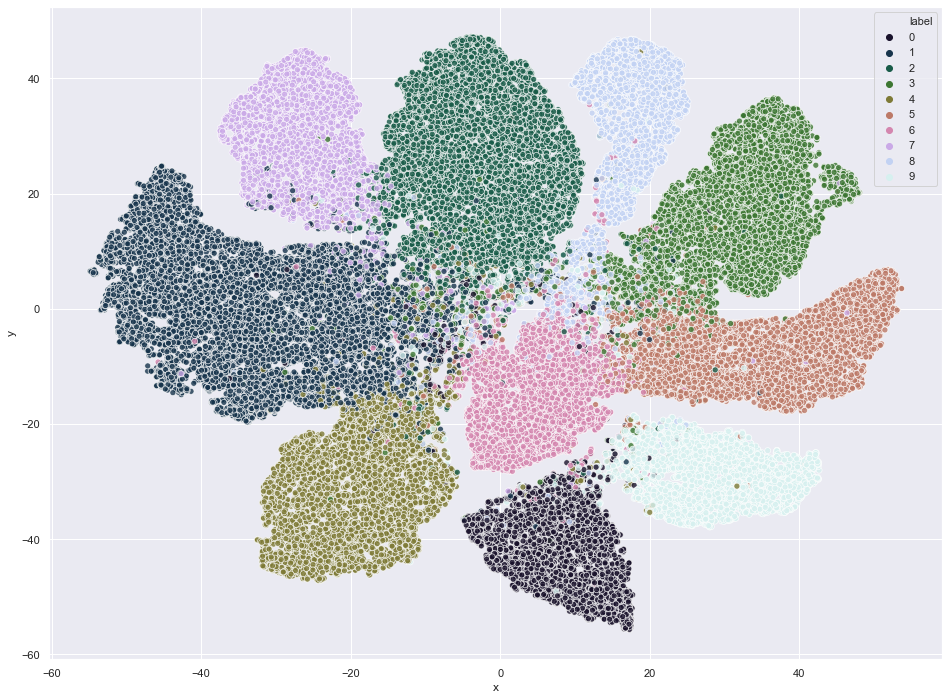

In [15]:
mode = res['source_train']
source_train_features_2d = plot_tsne(mode[1], mode[2], source_train_features_2d)

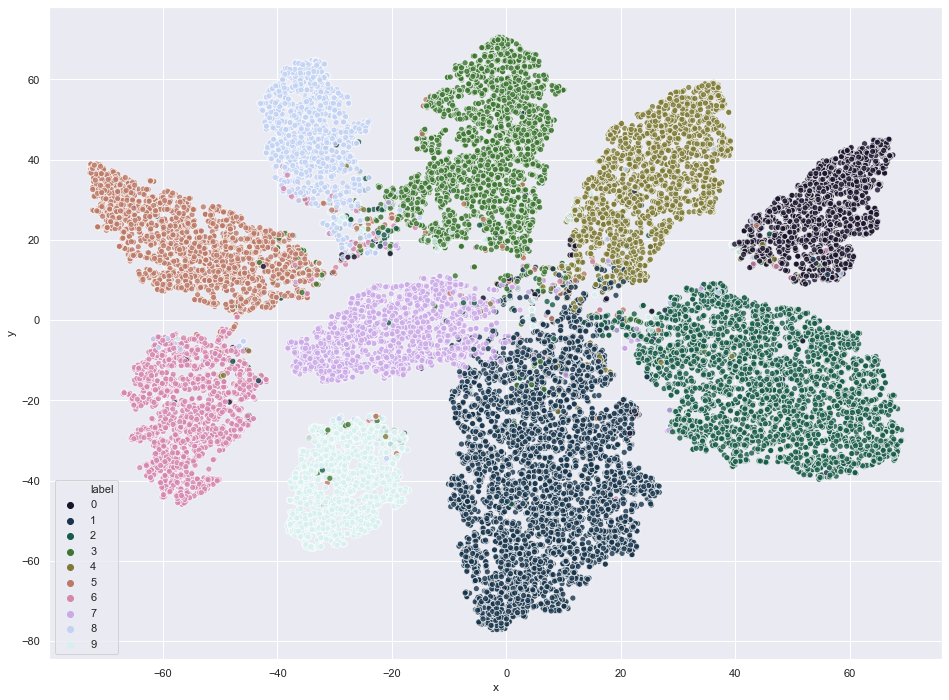

In [12]:
mode = res['source_valid']
source_valid_features_2d = plot_tsne(mode[1], mode[2], source_valid_features_2d)

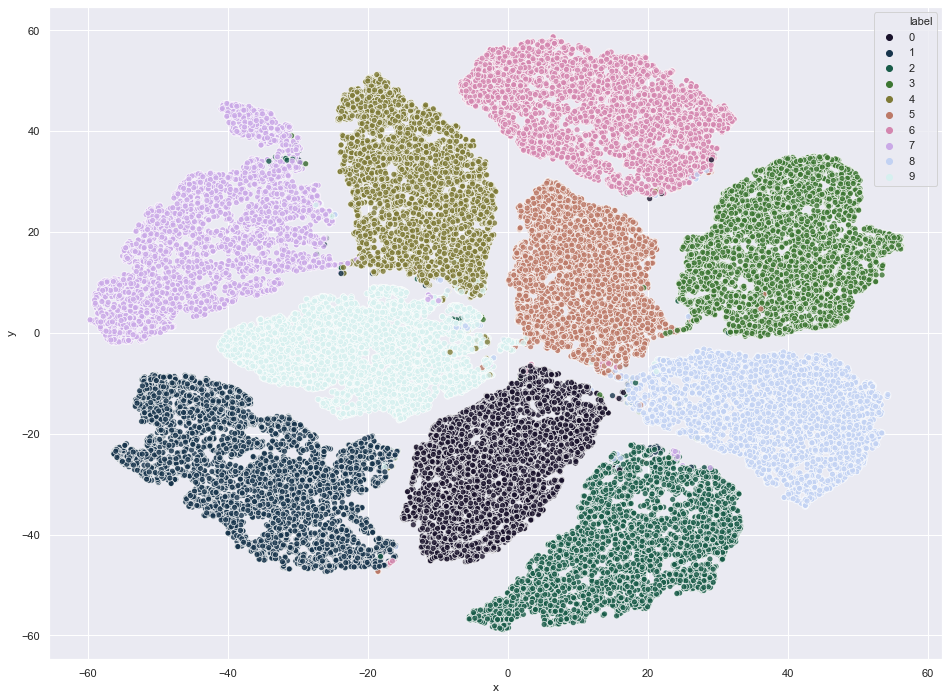

In [13]:
mode = res['target_train']
target_train_features_2d = plot_tsne(mode[1], mode[2], target_train_features_2d)

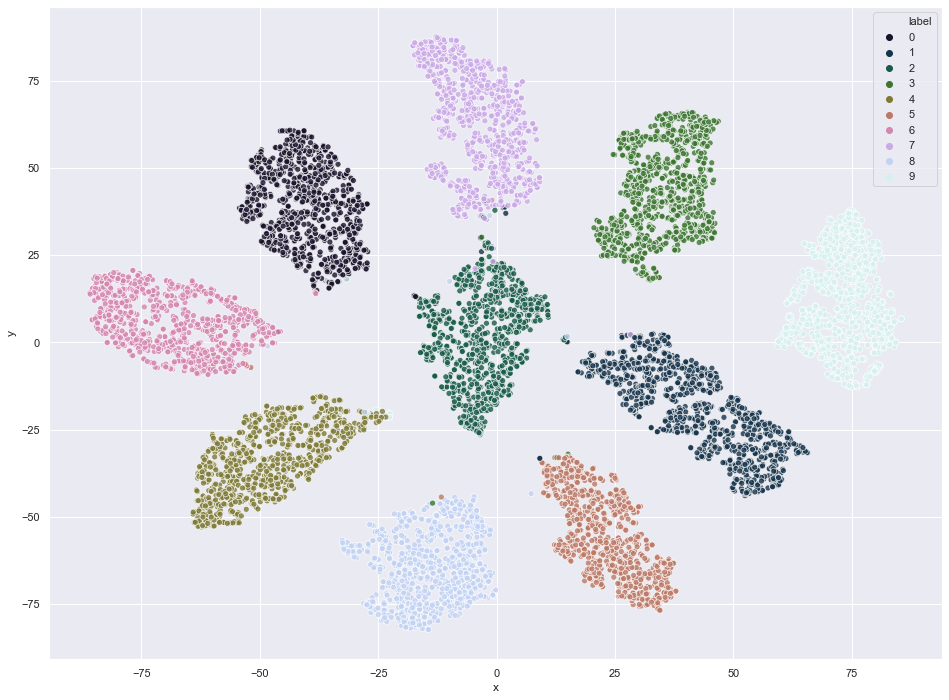

In [14]:
mode = res['target_valid']
target_valid_features_2d = plot_tsne(mode[1], mode[2], target_valid_features_2d)

In [20]:
data_source = res['source_valid']
data_target = res['target_valid']

source_data, source_label = data_source[1][:10000], data_source[2][:10000]
target_data, target_label = data_target[1], data_target[2]

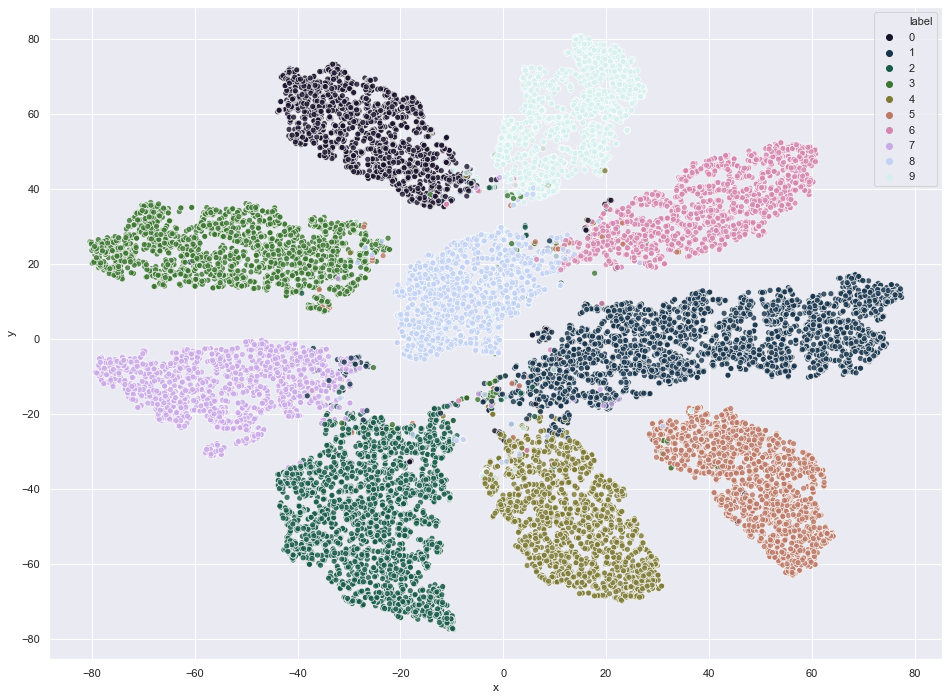

In [25]:
valid_features_2d = plot_tsne(np.vstack([source_data, target_data]), 
                              np.hstack([source_label, target_label]))

In [94]:
def plot_pair_distributions(features_2d, labels):
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(16, 12))
    df = pd.DataFrame(features_2d[0], columns=['x', 'y'])
    df['Source label'] = labels[0]
    sns.scatterplot(
        x="x", y="y",
        hue="Source label",
        palette=sns.hls_palette(10, l=0.5, s=1),
        data=df,
        legend="brief",
        alpha=0.8,
        ax=axs
    )
    df = pd.DataFrame(features_2d[1], columns=['x', 'y'])
    df['Target label'] = labels[1]
    sns.scatterplot(
        x="x", y="y",
        hue="Target label",
        palette=sns.hls_palette(10, l=.5, s=.5),
        data=df,
        legend="brief",
        alpha=0.8,
        ax=axs
    )

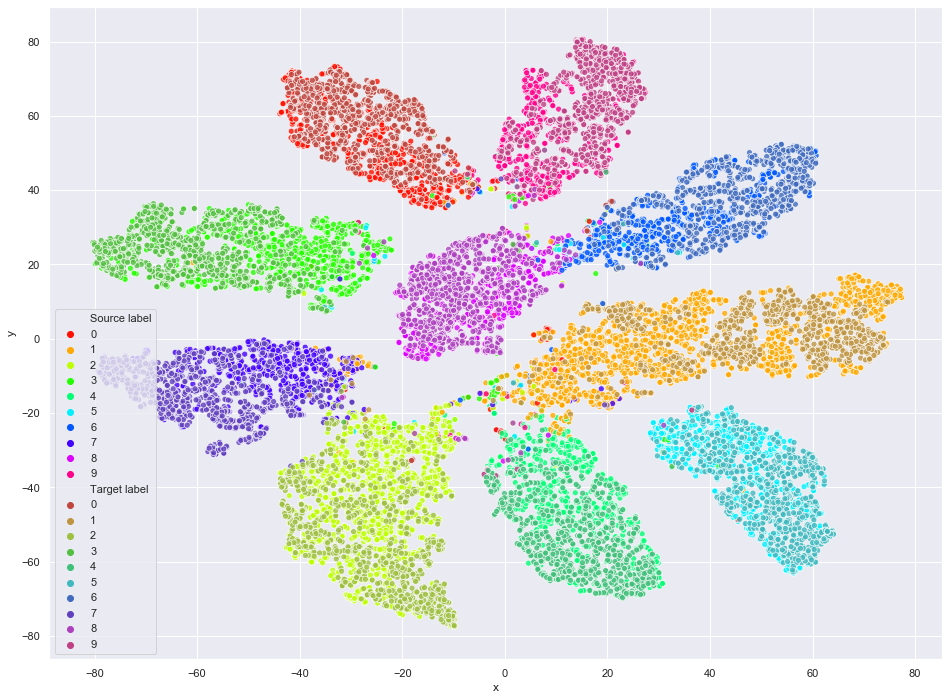

In [95]:
plot_pair_distributions([valid_features_2d[:10000], valid_features_2d[10000:]], [source_label, target_label])

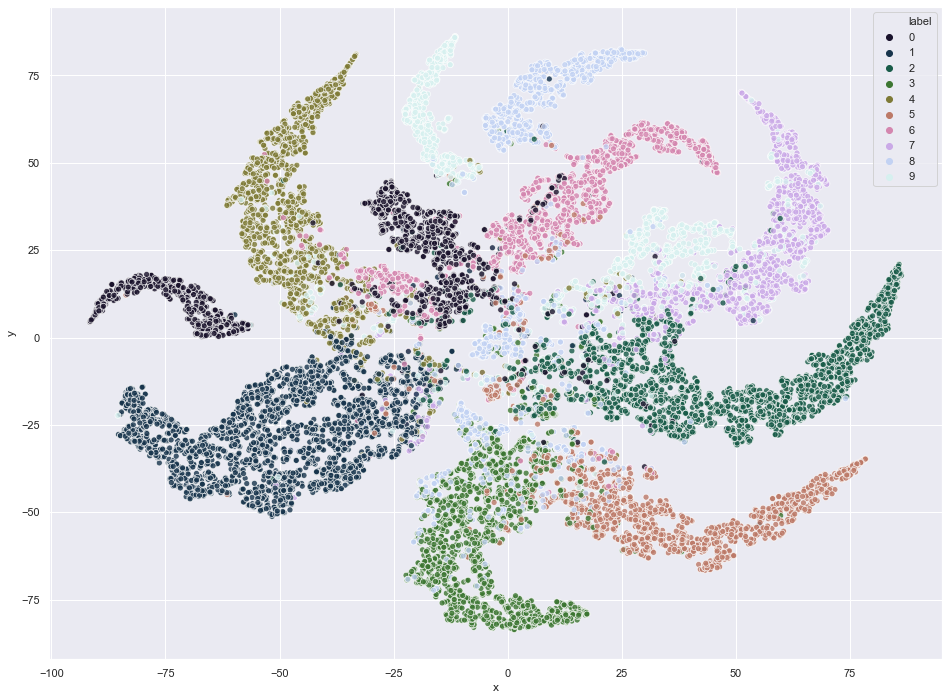

In [105]:
data_source = res_baseline['source_valid']
data_target = res_baseline['target_valid']

source_data, source_label = data_source[1][:10000], data_source[2][:10000]
target_data, target_label = data_target[1], data_target[2]

valid_features_2d = plot_tsne(np.vstack([source_data, target_data]), 
                              np.hstack([source_label, target_label]))

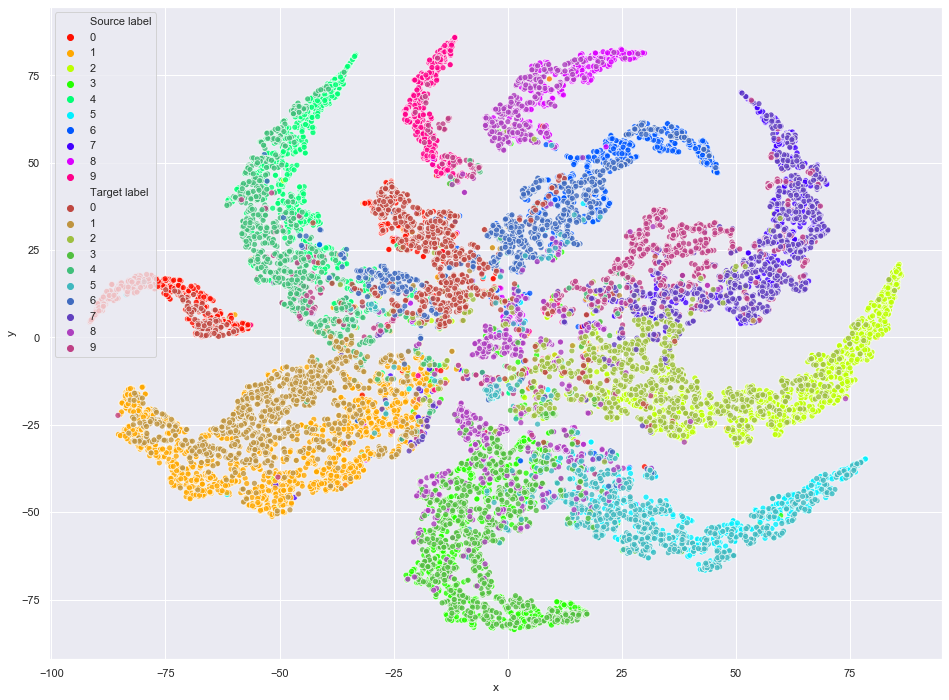

In [106]:
plot_pair_distributions([valid_features_2d[:10000], valid_features_2d[10000:]], [source_label, target_label])